## Logistic Regression

### The objective of the notebook is to identify customer who would churn in the future.

#### We will start with importing major libraries required for building and validating the model.
Along with sklearn for linear models and matplotlib for plotting the features, we have an additional library of scorefast (scorefastlib) for importing data from the ScoreFast platform as well as deploying the model on ScoreFast platform. 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
from io import StringIO
from scorefastlib.utils import read_dataset
import seaborn as sns
from sklearn.metrics import classification_report
from scorefastlib.utils import deploy_model
import pickle
from sklearn.exceptions import DataConversionWarning
%matplotlib inline

To load data stored in the platform, we call read_dataset along with the id of the dataset and AUTH_TOKEN.
The features of the dataset are annonymised and the target variable "churn/not churned" is called variable "P". 1 indicates churned while 0 indicates not churned.

In [2]:
%env AUTH_TOKEN=58bc8714afbabfc792891ecc3df11e8794818801
dataset = read_dataset("1638")
train = pd.read_csv(StringIO(dataset))
train=pd.read_csv("train.csv")
train.set_index('id',inplace=True)
target='P'
train.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
id,,,,,,,,,,,,,,,,
1,b,18.42,10.415,y,p,aa,v,0.125,t,f,0,f,g,120.0,375,1
2,a,21.75,11.750,u,g,c,v,0.250,f,f,0,t,g,180.0,0,1
3,b,30.17,1.085,y,p,c,v,0.040,f,f,0,f,g,170.0,179,1
4,b,22.67,2.540,y,p,c,h,2.585,t,f,0,f,g,0.0,0,0
5,a,36.00,1.000,u,g,c,v,2.000,t,t,11,f,g,0.0,456,0


Splitting the dataset before any feature engineering into new_train (ntrain) and new_test (ntest).

In [3]:
x_train,x_test,y_train,y_test=train_test_split(train.drop(columns=['P'],axis=1),train.P,test_size=.25,random_state=101)
ntrain=pd.concat([x_train,y_train],axis=1)
ntest=pd.concat([x_test,y_test],axis=1)
print("Training data size {}  and Test data size {}".format(ntrain.shape,ntest.shape))
del train

Training data size (414, 16)  and Test data size (138, 16)


### Churn rate distribution

Based on the distribution of the churn rate, the data is fairly balanced with the churn rate = 56.04%

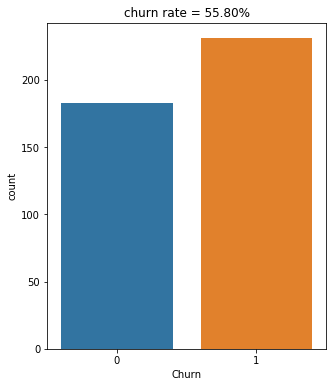

In [4]:
plt.figure(figsize=(5,6))
sns.countplot(data=ntrain,x="P")
plt.title("churn rate = {:.2f}%".format(ntrain.P.value_counts()[1]*100/ntrain.shape[0]))
plt.xlabel("Churn")
plt.show()

### Exploratory analysis to identify features which could explain the churn rate for customers.

Based on the below result, dataset contains null values

In [5]:
ntrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 407 to 524
Data columns (total 16 columns):
A    406 non-null object
B    410 non-null float64
C    414 non-null float64
D    410 non-null object
E    410 non-null object
F    408 non-null object
G    408 non-null object
H    414 non-null float64
I    414 non-null object
J    414 non-null object
K    414 non-null int64
L    414 non-null object
M    414 non-null object
N    407 non-null float64
O    414 non-null int64
P    414 non-null int64
dtypes: float64(4), int64(3), object(9)
memory usage: 75.0+ KB


Variable "D" and "E" are perfectly correlated based on the below cross-tabulation so removing "E" from both ntrain and ntest

In [6]:
d_v_e=pd.crosstab(ntrain.D,ntrain.E)
print(d_v_e)
del ntrain['E']
del ntest['E']
ntrain.loc[ntrain.D=="l","D"]="u"

E    g  gg   p
D             
l    0   1   0
u  310   0   0
y    0   0  99


Summarising numeric columns to check their distributions

In [7]:
ntrain.describe()

,B,C,H,K,N,O,P
count,410.000000,414.000000,414.000000,414.000000,407.000000,414.000000,414.000000
mean,31.539878,4.779940,2.294771,2.347826,172.552826,1054.678744,0.557971
std,12.016014,5.021112,3.535105,4.369693,158.963984,4472.603043,0.497229
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.500000,0.875000,0.210000,0.000000,54.000000,0.000000,0.000000
50%,28.250000,2.710000,1.000000,0.000000,144.000000,5.000000,1.000000
75%,38.772500,7.593750,2.750000,3.000000,260.000000,347.500000,1.000000
max,80.250000,28.000000,28.500000,40.000000,1160.000000,51100.000000,1.000000


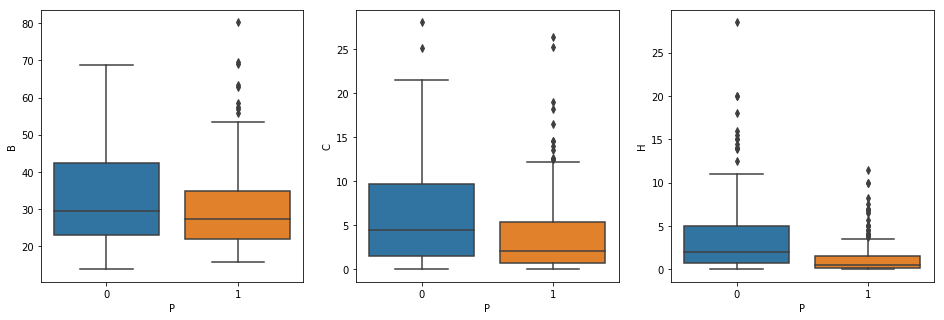

In [8]:
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
sns.boxplot("P","B",data=ntrain,ax=ax1)
sns.boxplot("P","C",data=ntrain,ax=ax2)
sns.boxplot("P","H",data=ntrain,ax=ax3)

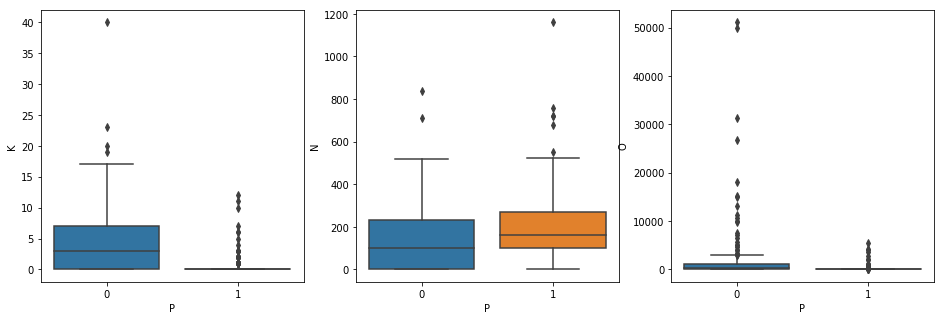

In [9]:
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
sns.boxplot("P","K",data=ntrain,ax=ax1)
sns.boxplot("P","N",data=ntrain,ax=ax2)
sns.boxplot("P","O",data=ntrain,ax=ax3)

Below are graphs to identify which of the Categorical variables explains churn of customers.

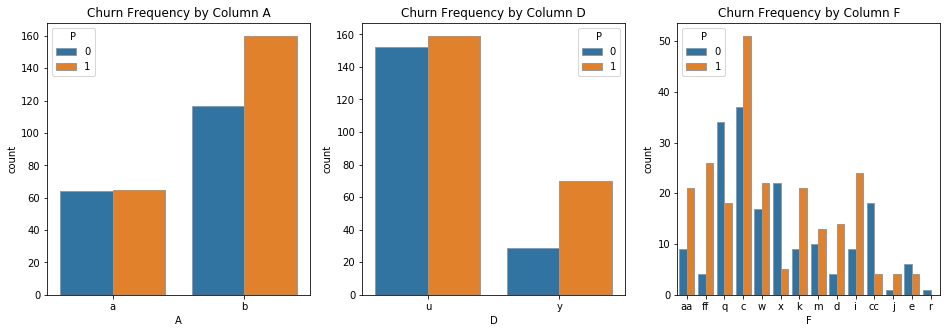

In [10]:
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
ax1.set(title="Churn Frequency by Column A")
ax2.set(title="Churn Frequency by Column D")
ax3.set(title="Churn Frequency by Column F")
#fig,ax=plt.subplots(ncols=3)
sns.countplot(x="A", hue="P",edgecolor=".6",data=ntrain,ax=ax1)
sns.countplot(x="D", hue="P",edgecolor=".6",data=ntrain,ax=ax2)
sns.countplot(x="F", hue="P",edgecolor=".6",data=ntrain,ax=ax3)

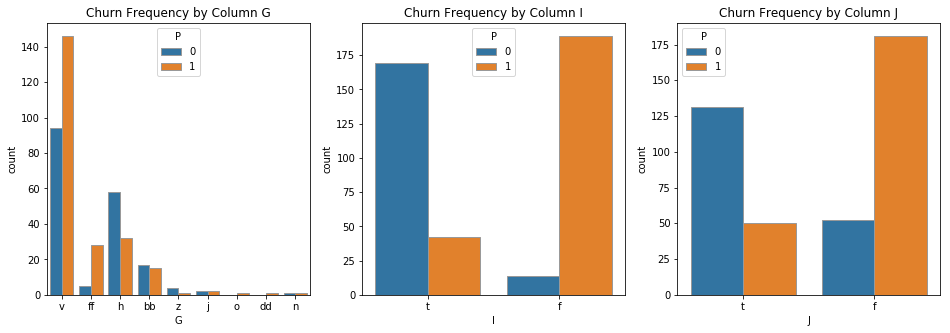

In [11]:
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
ax1.set(title="Churn Frequency by Column G")
ax2.set(title="Churn Frequency by Column I")
ax3.set(title="Churn Frequency by Column J")
#fig,ax=plt.subplots(ncols=3)
sns.countplot(x="G", hue="P",edgecolor=".6",data=ntrain,ax=ax1)
sns.countplot(x="I", hue="P",edgecolor=".6",data=ntrain,ax=ax2)
sns.countplot(x="J", hue="P",edgecolor=".6",data=ntrain,ax=ax3)

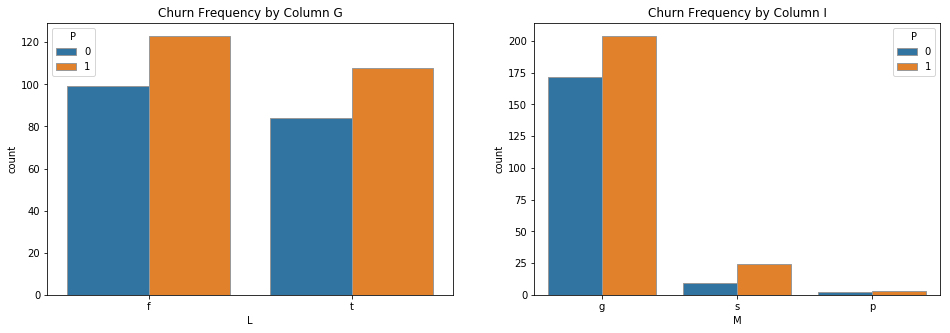

In [12]:
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set(title="Churn Frequency by Column G")
ax2.set(title="Churn Frequency by Column I")
ax3.set(title="Churn Frequency by Column J")
#fig,ax=plt.subplots(ncols=3)
sns.countplot(x="L", hue="P",edgecolor=".6",data=ntrain,ax=ax1)
sns.countplot(x="M", hue="P",edgecolor=".6",data=ntrain,ax=ax2)

### Feature Engineering based on the above exploratory analysis

Since there are missing values in the dataset, we need to treat it before applying logistic regression.The treatment steps are as follows:

-> Fill median value in Column B and column N using only ntrain data (both are numeric features).

-> Fill categorical value based on their distributions.

-> Replace column F and column G with their respective categorical means. 

In [13]:
mn_b=np.nanmedian(ntrain.B)
mn_n=np.nanmedian(ntrain.N)
fill_dict={'A':'b','D':'u','F':'NA','G':'NA','B':mn_b,'N':mn_n}
ntrain=ntrain.fillna(fill_dict)
ntrain.loc[ntrain.F.isin(['NA','r','j']),'F']='new'
ntrain.loc[~ntrain.G.isin(['v','h','ff','bb']),"G"]="other"
f_mean=ntrain.groupby('F')[target].mean().to_frame()
f_mean.reset_index(inplace=True)
g_mean=ntrain.groupby('G')[target].mean().to_frame()
g_mean.reset_index(inplace=True)

In [14]:
def set_data(trn,fill_dict,f_mean,g_mean):
    trn=trn.fillna(fill_dict)
    trn.loc[~trn.G.isin(['v','h','ff','bb']),"G"]="other"
    trn.loc[trn.F.isin(['NA','r','j']),'F']='new'
    trn=trn.merge(f_mean,how='left',on='F')
    trn=trn.merge(g_mean,how='left',on='G')
    trn.rename(columns={"P":"P_G","P_x":"P","P_y":"P_F"},inplace=True)
    trn.drop(columns=['F','G'],axis=1,inplace=True)
    return(trn)

Processing ntrain and ntest data in the same fashion to maintain symmetry.

In [15]:
ntrain_model=set_data(ntrain.copy(),fill_dict,f_mean,g_mean)
ntest_model=set_data(ntest.copy(),fill_dict,f_mean,g_mean)

Checking for missing values now

In [16]:
print("The number is missing values in ntrain = {} and ntest = {}".format(int(ntrain_model.isnull().values.any()),int(ntest_model.isnull().values.any())))

The number is missing values in ntrain = 0 and ntest = 0


Logistic regression takes only numeric features, so the categorical data needs to be converted into numeric data via dummy variables. Further the dataset is broken down into features and target.

In [17]:
cat=list(ntrain_model.columns[ntrain_model.dtypes==np.object])
ntrain_model=pd.get_dummies(ntrain_model,prefix=cat,prefix_sep='_')
ntest_model=pd.get_dummies(ntest_model,prefix=cat,prefix_sep='_')
ntest_model=ntest_model[ntrain_model.columns]
y=ntrain_model.P
x=ntrain_model.drop('P',axis=1)
x_test=ntest_model.drop('P',axis=1)
y_test=ntest_model.P

In [18]:
print("Training data size {}  and Test data size {}".format(x.shape,x_test.shape))

Training data size (414, 21)  and Test data size (138, 21)


Scale both ntrain and ntest data and fit a logistic regression model.

In [19]:
scl=StandardScaler()
x=scl.fit_transform(x)
regr=LogisticRegression()
regr.fit(x,y)
x_test=scl.transform(x_test)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


#### AUC or Area under the curve measures the classification power of the model

In [20]:
print("Using AUC as a measure to calcuate predictive power of the model")
y_pred_train=regr.predict(x)
y_pred_test=regr.predict(x_test)
print("The AUC for train data = {:.2f}".format(roc_auc_score(y_true=y,y_score=y_pred_train)))
print("The AUC for test data  = {:.2f}".format(roc_auc_score(y_true=y_test,y_score=y_pred_test)))

Using AUC as a measure to calcuate predictive power of the model
The AUC for train data = 0.89
The AUC for test data  = 0.83


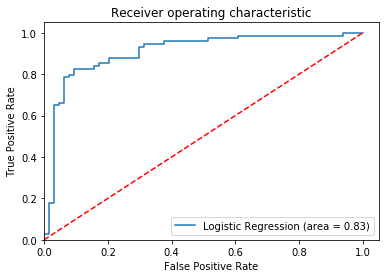

In [21]:
auc_test=roc_auc_score(y_true=y_test,y_score=y_pred_test)
fpr, tpr, thresholds = roc_curve(y_test, regr.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = {:0.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Classification report and the Accuracy for the test data

In [22]:
print("Classification report for the test data :")
print(classification_report(y_test,y_pred_test))

Classification report for the test data :
              precision    recall  f1-score   support

           0       0.82      0.83      0.82        64
           1       0.85      0.84      0.84        74

   micro avg       0.83      0.83      0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



In [23]:
print("The accuracy of the model on the test data: {:.2f}%".format(regr.score(x_test,y_test)*100))

The accuracy of the model on the test data: 83.33%


In [24]:
#deploy_model(model=regr, name="churn_model", dataset_id="1638", algorithm="LogisticRegression")